# Get NDVI information across reflectance files for F07A site
NDVI is calculated for all the reflectances' files. At each file NDVI value is obtained.

* **Importing libraries**

In [1]:
import h5py
import csv
import numpy as np
import os
import gdal
import matplotlib.pyplot as plt
import sys
from math import floor
from math import isnan
import time
import warnings
warnings.filterwarnings('ignore')


+ **Load function** `h5refl2array` **used during the sessions**

This function is to obtain the reflectances values as an array, get metadata values, and get wavelengths as hdf5 objects.

In [2]:
def h5refl2array(refl_filename):
    """h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
    reflectance array, select metadata, and wavelength dataset.
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            EPSG: coordinate reference system code (integer)
            *bad_band_window1: [1340 1445] range of wavelengths to ignore
            *bad_band_window2: [1790 1955] range of wavelengths to ignore 
            ext_dict: dictionary of spatial extent 
            extent: array of spatial extent (xMin, xMax, yMin, yMax)
            mapInfo: string of map information 
            *noDataVal: -9999.0
            projection: string of projection information
            *res: dictionary containing 'pixelWidth' and 'pixelHeight' values (floats)
            *scaleFactor: 10000.0
            shape: tuple of reflectance shape (y, x, # of bands)
        * Asterixed values are the same for all NEON AOP hyperspectral reflectance 
        files processed 2016 & after.
    wavelengths:
        Wavelengths dataset. This is the same for all NEON AOP reflectance hdf5 files.
        wavelengths.value[n-1] gives the center wavelength for band n 
    --------
    This function applies to the NEON hdf5 format implemented in 2016, which 
    applies to data acquired in 2016 & 2017 as of June 2017. Data in earlier 
    NEON hdf5 format is expected to be re-processed after the 2017 flight season. 
    --------
    Example
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5') """
    
    #Read in reflectance hdf5 file (include full or relative path if data is located in a different directory)
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info'].value

    #Extract no data value & set no data value to NaN
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    
    #Extract bad band windows
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    
    #Extract projection information
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    mapInfo_string = str(mapInfo); 
    mapInfo_split = mapInfo_string.split(",")
    
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = float(mapInfo_split[5])
    metadata['res']['pixelHeight'] = float(mapInfo_split[6])
    
    #Extract the upper left-hand corner coordinates from mapInfo
    xMin = float(mapInfo_split[3]) #convert from string to floating point number
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions
    xMax = xMin + (refl_shape[1]*metadata['res']['pixelWidth']) #xMax = left edge + (# of columns * resolution)",
    yMin = yMax - (refl_shape[0]*metadata['res']['pixelHeight']) #yMin = top edge - (# of rows * resolution)",
    metadata['extent'] = (xMin,xMax,yMin,yMax) #useful format for plotting
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax
    hdf5_file.close        
    
    return reflArray, metadata, wavelengths
    

* **Set the rectangular array containing the area from each BRDF flightline**

This image shows the **BRDF flight plan**:
<img src="http://neondataskills.org/images/neon-aop/ORNL_BRDF_flightlines.jpg", width='40%'>

In [3]:
BRDF_rectangle = np.array([[740315,3982265],[740928,3981839]], np.float)

* **Setup the point location**

In [4]:
x_coord = 740600
y_coord = 3982000

* **Determine if that point fall within the boundaries of the BRDF rectangle**
A function in case we want to check other coordinates later.

In [5]:

def check_point(x,y,rect):
    global y_index
    global x_index
    if BRDF_rectangle[0,0] <= x_coord <= BRDF_rectangle[1,0] \
        and BRDF_rectangle[1,1] <= y_coord <= BRDF_rectangle[0,1]:
        y_index = floor(x_coord - BRDF_rectangle[0,0])
        x_index = floor(BRDF_rectangle[0,1] - y_coord)
        msg= 'Point in bounding area'
    else:
        raise ValueError("Point not in bounding area, exiting")      
    return msg;
        
    

In [6]:
check_point(x_coord,y_coord,BRDF_rectangle)

'Point in bounding area'

* **Get the folder for the files of F07A site **

**Note:** Don't forget to put the `/` at the end of the folder name

In [7]:
h5_directory = '/Users/guillermoponce/Documents/GitHub/NEON_DATA/F07A/'

* **Loop through the folder to get just .h5 files, just in case other files are in this folder **

In [8]:
files = os.listdir(h5_directory)
h5_files =[i for i in files if i.endswith('.h5')]
#print(h5_files)
#my_array = []
#for j in h5_files:
#     my_array.append(j.split('_')[5] + '_NDVI')


* ** Loop through each file to get the information required to plot the reflectances first**

**From the lesson:**

Inside the for loop we will:

1. Read in the reflectance data and the associated metadata, but construct the file name from the generated file list
2. Determine the indexes of the water vapor bands (bad band windows) in order to mask out all of the bad bands
3. Read in the reflectance dataset using the NEON AOP H5 reader function
4. Check the first value the first value of the reflectance curve (actually any value). If it is equivalent to the NO DATA value, then coordainte chosen did not intersect a pixel for the flight line. We will just continue and move to the next line.
5. Apply NaN values to the areas contianing the bad bands
6. Split the contents of the file name so we can get the line number for labelling in the plot.
7. Plot the curve


In [9]:
fig=plt.figure()
ax = plt.subplot(111)

for file in h5_files:
    print('Working on '+ file)
    [reflArray, metadata, wavelengths] = h5refl2array(h5_directory+file)
    bad_band_window1 = (metadata['bad_band_window1'])
    bad_band_window2 = (metadata['bad_band_window2'])
    
    index_bad_window1 = [i for i, x in enumerate(wavelengths) \
                         if x > bad_band_window1[0] and x < bad_band_window1[1]]
    index_bad_window2 = [i for i, x in enumerate(wavelengths) \
                         if x > bad_band_window2[0] and x < bad_band_window2[1]]
    index_bad_windows = index_bad_window1 + index_bad_window2
    
    reflectance_curve = np.asarray(reflArray[y_index,x_index,:],dtype=np.float32)
   
    if reflectance_curve[0] == metadata['noDataVal']:
        continue
    # Set nan to those bad_windows
    reflectance_curve[index_bad_windows] = np.nan
    filename_split = file.split("_")
    
    # Add one line per file to the plot
    ax.plot(wavelengths, reflectance_curve/metadata['scaleFactor'], label = filename_split[5] + 'Reflectance')    
    

Working on NEON_D07_F07A_DP1_20160611_160444_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_160846_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_161228_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_161532_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_162007_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_162514_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_162951_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_163424_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_163945_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_164259_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_164809_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_165240_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_165711_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_170118_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_170538_reflectance_modif

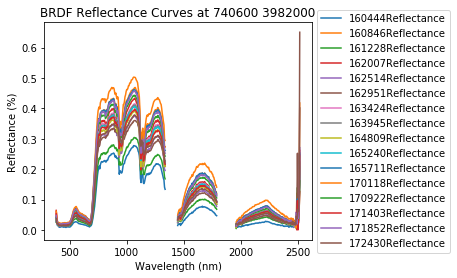

In [10]:
# Set up legend 
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
# Set labels
plt.title('BRDF Reflectance Curves at '+ str(x_coord) +' '+ str(y_coord))
plt.xlabel('Wavelength (nm)'); plt.ylabel('Reflectance (%)')

# Saving figure
fig.savefig('BRDF_uncertainty_at_'+ str(x_coord) +'_'+ \
            str(y_coord) + '.png', orientation='landscape', bbox_inches='tight', pad_inches=0.1,)

plt.show()

# Challenge 
### Get a plot with NDVI for each file reflectance
Extraction of NIR and RED is done within the loop used in the BRDF analysis lesson. 

In [11]:
# We can test for another coordinates
x_coord = 740600
y_coord = 3982000

check_point(x_coord,y_coord,BRDF_rectangle)

'Point in bounding area'

In [12]:
# Arrays to save x,y for the plot
my_ndvi=[]
my_files=[]
for file in h5_files:
    print('Working on '+ file)
    [reflArray, metadata, wavelengths] = h5refl2array(h5_directory+file)
    bad_band_window1 = (metadata['bad_band_window1'])
    bad_band_window2 = (metadata['bad_band_window2'])
 
    index_bad_window1 = [i for i, x in enumerate(wavelengths) \
                         if x > bad_band_window1[0] and x < bad_band_window1[1]]
    index_bad_window2 = [i for i, x in enumerate(wavelengths) \
                         if x > bad_band_window2[0] and x < bad_band_window2[1]]
    index_bad_windows = index_bad_window1 + index_bad_window2
    
    reflectance_curve = np.asarray(reflArray[y_index,x_index,:],dtype=np.float32)
   
    if reflectance_curve[0] == metadata['noDataVal']:
        continue

    reflectance_curve[index_bad_windows] = np.nan
    filename_split = file.split("_")
    
    # Get the bands to calculate NDVI for each file reflectance using NIR and Red bands
    nir = np.asarray(reflArray[y_index,x_index,90],dtype=np.float32)
    vis = np.asarray(reflArray[y_index,x_index,58],dtype=np.float32)
    ndvi = np.divide((nir-vis),(nir+vis))
    
    # Instead of plotting in the loop, arrays are populated
    my_ndvi.append(ndvi)
    my_files.append('F07A_' + filename_split[5]) 


Working on NEON_D07_F07A_DP1_20160611_160444_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_160846_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_161228_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_161532_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_162007_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_162514_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_162951_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_163424_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_163945_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_164259_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_164809_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_165240_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_165711_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_170118_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_170538_reflectance_modif

* ** Get the mean and std for all the files at the coordinates provided**

In [13]:
Nndvi = np.size(my_ndvi)
Nfiles = np.size(my_files)
meanNdvi = np.mean(my_ndvi)
meanStd = np.std(my_ndvi)

* ** Plotting NDVI, Mean, Std. **

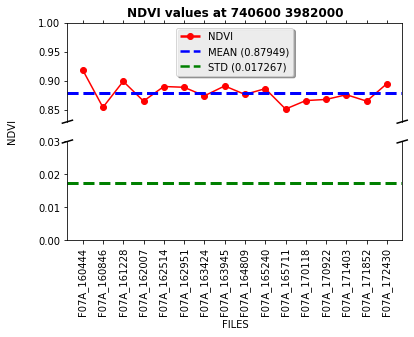

In [14]:
# Plot adapted from: http://matplotlib.org/examples/pylab_examples/broken_axis.html

pts = my_ndvi
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
ax.plot(pts,color='r', marker='o')
ax2.plot(pts)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(.83, 1)  # for NDVI Mean and NDVI values
ax2.set_ylim(0, 0.03)  # For the line of STD

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates

# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.axhline(meanNdvi, color='b', linestyle='dashed', linewidth=3)
ax2.axhline(meanStd, color='g', linestyle='dashed', linewidth=3)
ax.set_xticklabels(labels=my_files,rotation=90)
ax2.set_xticklabels(labels=my_files,rotation=90)

ax.set_xticks(np.arange(Nfiles))
ax2.set_xticks(np.arange(Nfiles))
ax.set_title(label='NDVI values at '+ str(x_coord) +' '+ str(y_coord),fontweight="bold")
ax.yaxis.set_label_coords(-0.15,-0.1)
ax.set_ylabel('NDVI')
ax2.set_xlabel('FILES')


# Legends 
legend = ax.legend(['NDVI', 'MEAN ('+str(meanNdvi)+')','STD (' + str(meanStd) + ')'], loc='upper center',shadow=True)
leg = ax.get_legend()

# Set color in the legend
leg.legendHandles[1].set_color('blue')
leg.legendHandles[2].set_color('green')
leglines = legend.get_lines()

# Change line style/width in the legend
for label in legend.get_lines():
    label.set_linestyle('dashed')
    label.set_linewidth(2.5)

plt.show()
f.savefig('NDVI_plot_of_values_at_'+ str(x_coord) +'_'+ \
            str(y_coord) + '.png', dpi=300,orientation='landscape', bbox_inches='tight', pad_inches=0.1,)


* **Testing some plotting features with Pandas**

I didn't use this option because wanted to do the broken y-axis option.

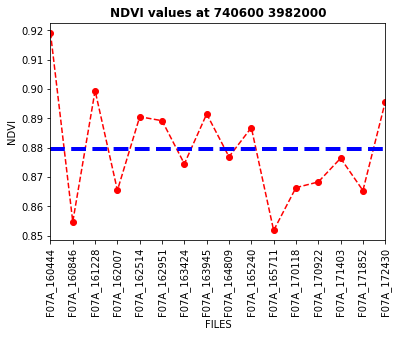

In [15]:
import pandas as pd

# Using this pandas dataframe Series method, we can access plot functions
s = pd.Series(
    my_ndvi,
    index = my_files
)
s
plt.title('NDVI values at '+ str(x_coord) +' '+ str(y_coord), fontweight="bold")
plt.ylabel('NDVI')
plt.xlabel('FILES')

ax = plt.gca()
##ax.tick_params(axis='x', colors='e')
##ax.tick_params(axis='y', colors='red')

#Plot the data:
my_colors = 'rgbkymc'  #red, green, blue, black, etc.

s.plot(x='month',ax=ax, linestyle='--', marker='o', color='r') 

ax.set_xticklabels(labels=my_files,rotation=90)
ax.set_xticks(np.arange(Nfiles))


plt.axhline(meanNdvi, color='b', linestyle='dashed', linewidth=4)

# I need to break axes to show std as in the plot above
#plt.axhline(meanStd, color='g', linestyle='dashed', linewidth=4)

plt.show()